In [1]:
import lib.display
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re

import joblib

from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt
from matplotlib import animation
from skimage import transform
from tqdm.auto import tqdm
from IPython.display import HTML, clear_output
import ipywidgets as widgets

from math import floor

In [36]:
logfile = '/Users/weinberz/Desktop/OPP_scramble.log'
basedir = '/Users/weinberz/UM Drive/50Hz Puffs/Analysis/OPP'
files = os.listdir(basedir)
excludes = ['0IYVHRNA','19CC75ZU','2TZWB6CN','3W70AV4V']
movies_list = [f for f in files if 'features' in f]
movies_list = [m for m in movies_list if m.split('.')[0] not in excludes]

In [4]:
def get_cargo_id(cell, logfile):
    content = open(logfile,'r').read()

    p = re.compile("(tfr|b2|mor).*"+cell+".*?\n")
    res = p.search(content)
    if res is not None:
        if res.group(1) == 'b2':
            return('B2')
        elif res.group(1) == 'mor':
            return('MOR')
        elif res.group(1) == 'tfr':
            return('TfR')
    
    raise NameError('Cell name not found in logfile.')

# Unlabeled Sample

In [4]:
features_list = []
for movie in movies_list:
    cell = movie.split('_')[0]
    features = pd.read_csv(basedir + os.sep + movie, index_col=0)
    features.loc[:, 'cell'] = cell
    features.loc[:, 'cargo'] =  get_cargo_id(cell, logfile)
    features_list.append(features)
    
sample = pd.concat(features_list, ignore_index=True)

In [6]:
training_fields = ['conv_perim', 'conv_area', 'lifetime_s',
    'randomness_s1', 'randomness_s2', 'cc11', 'cc12', 'cc13', 'cc21',
    'cc22', 'cc23', 'deltaf', 'tau', 'resid_dist', 'residuals_median',
    'residuals_std', 'snr_median', 'snr_std']

classifier = joblib.load('global_classifier.joblib')
new_pred_probs = np.zeros(len(sample))
ww = (1 - np.mean(labeled_sample['puff']))/np.mean(labeled_sample['puff'])
for tt in classifier.estimators_:
    tree_pred = tt.predict_proba(sample[training_fields])[:,1]
    new_pred_probs = new_pred_probs + tree_pred/(tree_pred + ww - ww*tree_pred)
new_pred_probs /= (1.0*len(classifier.estimators_))
sample['adj_proba'] = new_pred_probs

In [12]:
np.random.seed(237)
bins = [[0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0]]
n_samples = [36,  64,  84,  96, 100, 100,  96,  84,  64,  36]

In [13]:
binned_samples = []
for cargo in sample['cargo'].unique():
    cargo_sample = sample[sample['cargo']==cargo]
    for idx, bin_ in enumerate(bins):
        binned_sample = cargo_sample[(bin_[0] <= cargo_sample['adj_proba'].values) &
                                     (cargo_sample['adj_proba'].values < bin_[1])]
        replacement = len(binned_sample) < n_samples[idx]
        binned_sample = binned_sample.iloc[np.random.choice(len(binned_sample), size=n_samples[idx], replace=replacement)]
        binned_samples.append(binned_sample[['cell', 'particle', 'adj_proba', 'cargo']])

binned_samples = pd.concat(binned_samples, ignore_index = True)
binned_samples['score'] = None

In [64]:
np.random.seed(237)
subsample = binned_samples.loc[~(binned_samples['score'] >= 0), :]
cell_label = widgets.Label(value='')
particle_label = widgets.Label(value='')
labels = widgets.HBox([cell_label, particle_label])

centered_layout = widgets.Layout(align_items = 'center')

loading_widget = widgets.Label(value='Loading...')

puff_butt = widgets.Button(description='Puff!',
                           disabled=False,
                           button_style='',
                           tooltips='Puff',
                           icons='check')
np_butt = widgets.Button(description='Nonpuff!',
                           disabled=False,
                           button_style='',
                           tooltips='Nonpuff',
                           icons='times')
score_butt = widgets.HBox([np_butt, puff_butt])

header = widgets.VBox([labels, score_butt], layout=centered_layout)
summary_display = widgets.HBox([loading_widget])
full_display = widgets.VBox([header, summary_display], layout=centered_layout)
display(full_display)

def load_next_cell():
    global events
    global cells
    
    cell = next(cells, None)
    if cell is None:
        loading_widget.value = "You're done! Time to go home!"
        summary_display.children = [loading_widget]
    else:
        loading_widget.value = "Getting new cell..."
        summary_display.children = [loading_widget]
        cell_label.value = cell
        intensities = pd.read_csv(basedir + os.sep + cell + '_intensities.csv')
        events = [intensities.loc[intensities['particle'] == particle, :]
                  for particle in subsample.loc[subsample['cell'] == cell_label.value, 'particle'].unique()]
        np.random.shuffle(events)
        events = iter(events)

def display_and_load():
    global events
    
    event = next(events, None)
    if event is None:
        load_next_cell()
        event = next(events)
    
    loading_widget.value = ("Loading event with length %d..." % len(event['frame'].unique()))
    summary_display.children = [loading_widget]
    particle = event['particle'].values[0]
    particle_label.value = str(particle)
    summary_widgets = lib.display.plot_summary(event)
    summary_display.children = [widgets.VBox([widgets.HBox(summary_widgets[:2]), 
                                             summary_widgets[2]], layout=centered_layout)]

def call_puff(b):
    binned_samples.loc[(binned_samples['particle'] == int(particle_label.value)) &
                       (binned_samples['cell'] == cell_label.value), 'score'] = 1
    display_and_load()

def call_np(b):
    binned_samples.loc[(binned_samples['particle'] == int(particle_label.value)) &
                       (binned_samples['cell'] == cell_label.value), 'score'] = 0
    display_and_load()

puff_butt.on_click(call_puff)
np_butt.on_click(call_np)

cells = [cell for cell in subsample['cell'].unique()]
np.random.shuffle(cells)
cells = iter(cells)
events = iter(())

display_and_load()

In [74]:
#binned_samples = pd.read_csv('scored_binned_samples.csv', index_col=0)
#binned_samples.to_csv('scored_binned_samples-20191121.csv')

In [75]:
np.sum(binned_samples['score']>=0)

2190

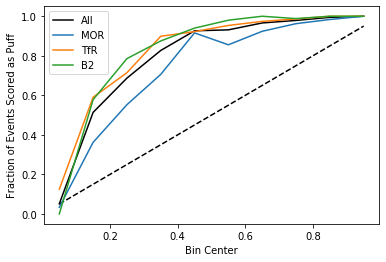

In [71]:
plt.figure()
xs = [res for res in map(np.mean, bins)]
plt.plot(xs, xs, linestyle='--', color='k')

ys = []
for idx, bin_ in enumerate(bins):
    binned_sample = binned_samples[(bin_[0] <= binned_samples['adj_proba'].values) &
                                   (binned_samples['adj_proba'].values < bin_[1])]
    ys.append(np.sum(binned_sample['score'] == 1)/np.sum(binned_sample['score'] >= 0))
plt.plot(xs, ys, label='All', color='k')

for cargo in binned_samples['cargo'].unique():
    ys = []
    for idx, bin_ in enumerate(bins):
        binned_sample = binned_samples[(bin_[0] <= binned_samples['adj_proba'].values) &
                                       (binned_samples['adj_proba'].values < bin_[1]) &
                                       (binned_samples['cargo'] == cargo)]
        ys.append(np.sum(binned_sample['score'] == 1)/np.sum(binned_sample['score'] >= 0))
    plt.plot(xs, ys, label=cargo)
    
plt.legend()
plt.xlabel('Bin Center')
plt.ylabel('Fraction of Events Scored as Puff')
plt.show()

# Labeled Sample

In [11]:
labeled_dir = 'data'

In [3]:
files = os.listdir(labeled_dir)
labeled_sample = pd.read_csv('labeled_sample-adj_proba.csv', index_col=0)

In [6]:
logfile = '/Volumes/Coatamer/Users/weinberz/UM Drive/OPP/OPP_scramble.log'
labeled_sample['cargo'] = [get_cargo_id(cell, logfile) for cell in labeled_sample['cell']]

In [9]:
np.random.seed(237)
bins = [[0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0]]
n_samples = [36,  64,  84,  96, 100, 100,  96,  84,  64,  36]

binned_labeled_samples = []
for cargo in labeled_sample['cargo'].unique():
    cargo_sample = labeled_sample[labeled_sample['cargo']==cargo]
    for idx, bin_ in enumerate(bins):
        binned_sample = cargo_sample[(bin_[0] <= cargo_sample['adj_proba'].values) &
                                     (cargo_sample['adj_proba'].values < bin_[1])]
        replacement = len(binned_sample) < n_samples[idx]
        binned_sample = binned_sample.iloc[np.random.choice(len(binned_sample), size=n_samples[idx], replace=replacement)]
        binned_labeled_samples.append(binned_sample[['cell', 'particle', 'adj_proba', 'cargo']])

binned_labeled_samples = pd.concat(binned_labeled_samples, ignore_index = True)
binned_labeled_samples['score'] = None

In [12]:
np.random.seed(237)
subsample = binned_labeled_samples.loc[~(binned_labeled_samples['score'] >= 0), :]
cell_label = widgets.Label(value='')
particle_label = widgets.Label(value='')
labels = widgets.HBox([cell_label, particle_label])

centered_layout = widgets.Layout(align_items = 'center')

loading_widget = widgets.Label(value='Loading...')

puff_butt = widgets.Button(description='Puff!',
                           disabled=False,
                           button_style='',
                           tooltips='Puff',
                           icons='check')
np_butt = widgets.Button(description='Nonpuff!',
                           disabled=False,
                           button_style='',
                           tooltips='Nonpuff',
                           icons='times')
score_butt = widgets.HBox([np_butt, puff_butt])

header = widgets.VBox([labels, score_butt], layout=centered_layout)
summary_display = widgets.HBox([loading_widget])
full_display = widgets.VBox([header, summary_display], layout=centered_layout)
display(full_display)

def load_next_cell():
    global events
    global cells
    
    cell = next(cells, None)
    if cell is None:
        loading_widget.value = "You're done! Time to go home!"
        summary_display.children = [loading_widget]
    else:
        loading_widget.value = "Getting new cell..."
        summary_display.children = [loading_widget]
        cell_label.value = cell
        intensities = pd.read_csv(labeled_dir + os.sep + cell + '_intensities.csv')
        events = [intensities.loc[intensities['particle'] == particle, :]
                  for particle in subsample.loc[subsample['cell'] == cell_label.value, 'particle'].unique()]
        np.random.shuffle(events)
        events = iter(events)

def display_and_load():
    global events
    
    event = next(events, None)
    if event is None:
        load_next_cell()
        event = next(events)
    
    loading_widget.value = ("Loading event with length %d..." % len(event['frame'].unique()))
    summary_display.children = [loading_widget]
    particle = event['particle'].values[0]
    particle_label.value = str(particle)
    summary_widgets = lib.display.plot_summary(event)
    summary_display.children = [widgets.VBox([widgets.HBox(summary_widgets[:2]), 
                                             summary_widgets[2]], layout=centered_layout)]

def call_puff(b):
    binned_labeled_samples.loc[(binned_labeled_samples['particle'] == int(particle_label.value)) &
                       (binned_labeled_samples['cell'] == cell_label.value), 'score'] = 1
    display_and_load()

def call_np(b):
    binned_labeled_samples.loc[(binned_labeled_samples['particle'] == int(particle_label.value)) &
                       (binned_labeled_samples['cell'] == cell_label.value), 'score'] = 0
    display_and_load()

puff_butt.on_click(call_puff)
np_butt.on_click(call_np)

cells = [cell for cell in subsample['cell'].unique()]
np.random.shuffle(cells)
cells = iter(cells)
events = iter(())

display_and_load()

In [18]:
binned_labeled_samples.to_csv('binned_labeled_samples_20191121.csv')

/Volumes/Coatamer/Users/weinberz/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


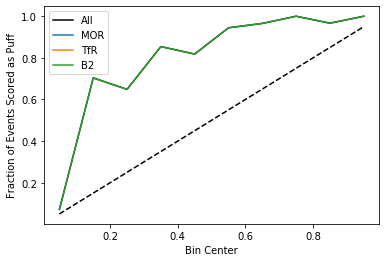

In [16]:
plt.figure()
xs = [res for res in map(np.mean, bins)]
plt.plot(xs, xs, linestyle='--', color='k')

ys = []
for idx, bin_ in enumerate(bins):
    binned_sample = binned_labeled_samples[(bin_[0] <= binned_labeled_samples['adj_proba'].values) &
                                   (binned_labeled_samples['adj_proba'].values < bin_[1])]
    ys.append(np.sum(binned_sample['score'] == 1)/np.sum(binned_sample['score'] >= 0))
plt.plot(xs, ys, label='All', color='k')

for cargo in binned_labeled_samples['cargo'].unique():
    ys = []
    for idx, bin_ in enumerate(bins):
        binned_sample = binned_labeled_samples[(bin_[0] <= binned_labeled_samples['adj_proba'].values) &
                                       (binned_labeled_samples['adj_proba'].values < bin_[1]) &
                                       (binned_labeled_samples['cargo'] == cargo)]
        ys.append(np.sum(binned_sample['score'] == 1)/np.sum(binned_sample['score'] >= 0))
    plt.plot(xs, ys, label=cargo)
    
plt.legend()
plt.xlabel('Bin Center')
plt.ylabel('Fraction of Events Scored as Puff')
plt.show()